# Rockall Trough glider section - HEOF analysis

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.features.matfile_functions as matlab_fct
import src.features.RT_EOF_functions as rt_eof
import src.set_paths as sps
import src.RT_parameters as rtp
import src.features.RT_visualise as rtv

In [2]:
from matplotlib import pyplot as plt
import dask
import datetime
import gsw
import numpy as np
import pandas as pd
import mat73
import xarray as xr
from pathlib import Path
import xeofs as xe
import warnings
warnings.filterwarnings('ignore')
xr.set_options(display_expand_attrs=False)
%matplotlib inline

## Output praemble

In [3]:
date_str_start = '2020'
date_str_end = '2023'
fn_version = 'v0'
script_name = f"2.1_Rockall_Trough_glider_EW_HEOF_{date_str_start[:-2]}_{date_str_end[:-2]}"

# output figures
fig_out_path = (sps.local_fig_dir/f"{script_name}")
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

## Input Praemble

In [4]:
# mooring intput data
fn_in_version = 'v1'
fn_base_grid = "Rockall_Trough_mooring_gridded_TSUV"
fn_base_stack = "Rockall_Trough_mooring_stacked_TSUV"
date_str_start_moor = '201407'
date_str_end_moor = '202207'

RT_mooring_fn = f"{fn_base_grid}_{date_str_start_moor}_{date_str_end_moor}_{fn_in_version}.nc"
file_name_in_stack = f"{fn_base_stack}_{date_str_start_moor}_{date_str_end_moor}_{fn_in_version}.nc"

# transport input data
fn_in_version = 'v0'
fn_base_grid = "Rockall_Trough_transport_3D_time_series"
date_str_start_moor = '201407'
date_str_end_moor = '202207'
RT_transp_grid_fn = f"{fn_base_grid}_{date_str_start_moor}_{date_str_end_moor}_{fn_in_version}.nc"

# Load data

In [5]:
# Rockall Trough mooring location
ds_RT_loc=rtd.load_RT_loc()

# stacked RT mooing data
ds_RT_stacked = xr.open_dataset((sps.RT_mooring_data_path/file_name_in_stack))

# load gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((sps.RT_mooring_data_path/RT_mooring_fn))

# Extrapolate top and linearly interpolate over gaps
ds_RT = rtf.prep_mooring_data_for_transport_calc(ds_RT,ds_RT_loc)

# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((sps.GEBCO_data_path/sps.GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS = rtd.load_glorys('RTADCP',ds_RT.TIME.min(),ds_RT.TIME.max())


Data is in GLORYS reanlysis and interim period


In [6]:
#Reconstructed Rockall Trough transport section
ds_q_RT = xr.open_dataset((sps.RT_transport_data_path_v0/RT_transp_grid_fn))
ds_q_RT_full = ds_q_RT.sel(lon=slice(ds_RT_loc.lon_RTEB.values,None))
ds_q_RT = ds_q_RT_full.sel(depth=slice(None,1000))


In [7]:
#load glider
ds_glider = matlab_fct.load_glider_mat(sps.glider_data_path,sps.glider_fn)
ds_glider_nan = rt_eof.add_nan_glider_sections(ds_glider)

# Analysis

#### To Do
- [ ] Calc some stats for glider reconstruction
- [ ] Calc transport instead of spatially average velocities
- [ ] Add attributes
- [ ] Repeat using EOFs instead of HEOFs --> see 2.0_Rockall_Trough_glider_EW_EOF_2020_2022.ipynb
- [ ] Repeat using extended EOFs instead of HEOFs

#### Naming conventio
- Glider - velocity from glider sections May 2020- Feb 2023
- RT EW full - full data set (Jul 2014- Jul 2022) - velocity section from eastern wedge transport reconstruction (Fraser et al., 2022)  
- RT EW 2020-2022 - data from period Jan 2020- Jul 2022 - velocity section from eastern wedge transport reconstruction (Fraser et al., 2022)  
- RT EW resampled - data interpolated on Glider time stamp (May 20-Jul 23) -velocity section from eastern wedge transport reconstruction (Fraser et al., 2022) 
    !NOTE: RT EW time series ends in July 2022 and does not cover full glider timeseries!

## Mean velocity section

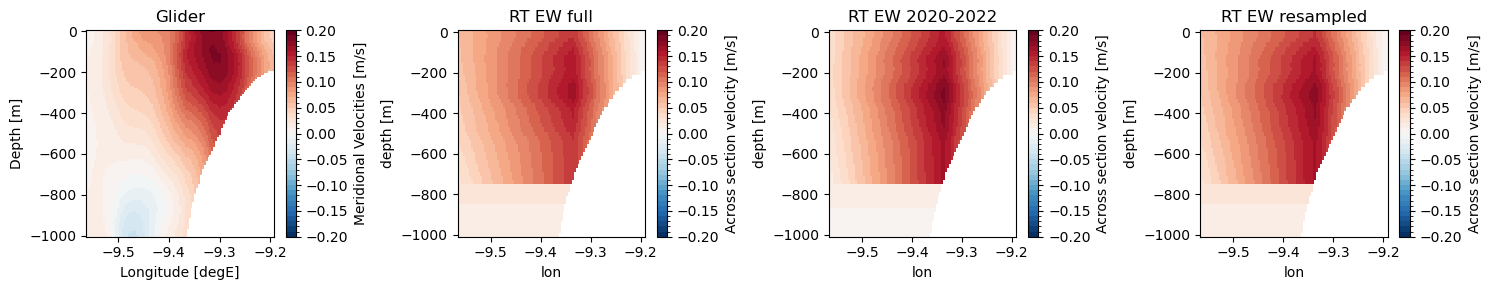

In [8]:
fig,axs = plt.subplots(1,4,figsize=[15,3])
vmin,vmax,levs=-0.2,0.2,41
ds_q_RT['depth']=-1*ds_q_RT.depth
ax=axs[0]
ds_glider.vcur.mean(['time']).plot(x='lon',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('Glider')
ax=axs[1]
ds_q_RT.v.mean(['TIME']).plot(x='lon',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('RT EW full')
ax=axs[2]
ds_q_RT.v.interp(TIME=ds_glider.time.values
                   ).mean(['TIME']).plot(x='lon',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('RT EW 2020-2022')
ax=axs[3]
ds_q_RT.v.sel(TIME=slice('2020',None)
                ).mean(['TIME']).plot(x='lon',ax=ax,vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
ax.set_title('RT EW resampled')
plt.tight_layout()

We are missing the undercurrent in ER EW reconstruction.

## Seasonal Cycle - spatially averaged velocity

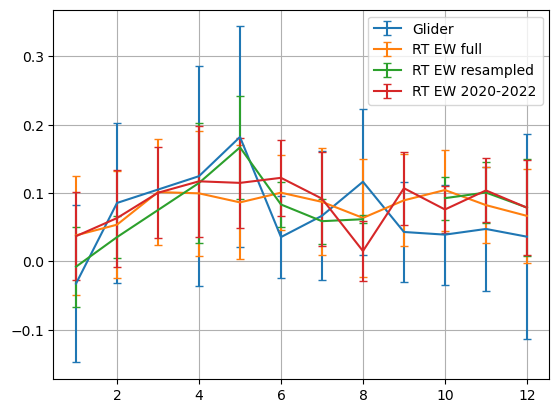

In [9]:
color='C0'
m=ds_glider.vcur.groupby('time.month').mean(['time','lon','depth'])
d=ds_glider.vcur.groupby('time.month').std('time').mean(['lon','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='Glider')

color='C1'
m = ds_q_RT.v.groupby('TIME.month').mean(['TIME','lon','depth']) 
d=ds_q_RT.v.groupby('TIME.month').std('TIME').mean(['lon','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='RT EW full')

color='C2'
m = ds_q_RT.v.interp(TIME=ds_glider.time.values
                ).groupby('TIME.month').mean(['TIME','lon','depth'])
d=ds_q_RT.v.interp(TIME=ds_glider.time.values
                ).groupby('TIME.month').std('TIME').mean(['lon','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='RT EW resampled')

color='C3'
m = ds_q_RT.v.sel(TIME=slice('2020',None)
                ).groupby('TIME.month').mean(['TIME','lon','depth'])
d=ds_q_RT.v.sel(TIME=slice('2020',None)
                ).groupby('TIME.month').std('TIME').mean(['lon','depth'])
plt.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='RT EW 2020-2022')
plt.legend()
plt.grid()

When resampled on the same time stamp, the glider and the RT EW reconstruction are quite silimar. However, when compared to the full time series it is clear that the seasonal cycle reconstructed from the glider still suffers from aliasing.

August high velocities in glider section dominated by values observed in August 2022 (see figure below). Unfortunatly the moored transport time series ends in July 2022!

## Time series in original resolution 2020-2022 - spatially averaged velocity

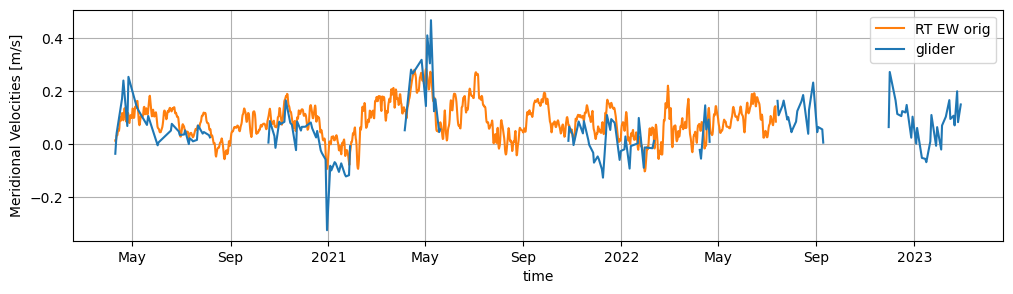

In [10]:
ds_q_RT.v.sel(TIME=slice(ds_glider.time.min().values,ds_glider.time.max().values)
                ).mean(['lon','depth']).plot.line('-',label='RT EW orig',figsize=[12,3],color='C1')
ds_glider_nan.vcur.mean(['lon','depth']).plot.line('-',label='glider',color='C0')
# ds_q_RT.v.interp(TIME=ds_glider.time.values
#                 ).mean(['lon','depth']).plot.line('-',label='RT EW resampled')
plt.legend()
plt.grid()

# HEOF

### Idealized dataset
- Barotropic signal varying only in time with a period of T=365 days + Travelling wave with a  period of T=73 days
- Amplitude of annual signal is 1.5 higher than travelling wave

#### Snapshots of idealiezed dataset for different time periods

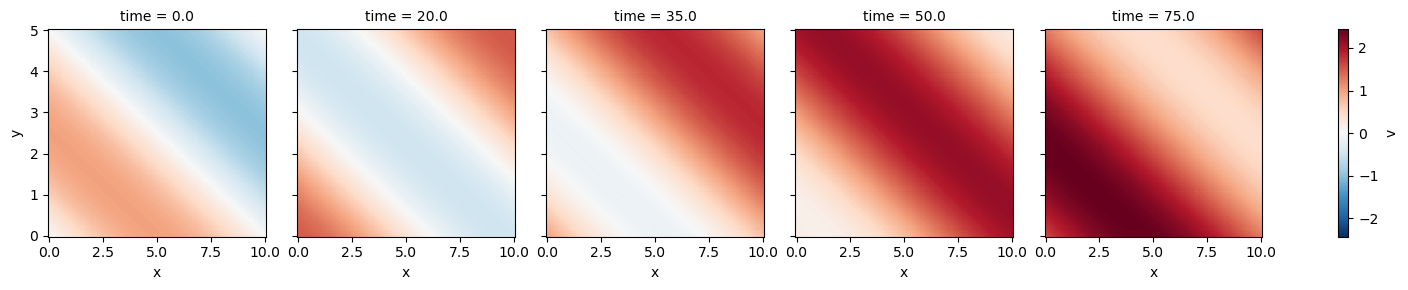

In [11]:
T=73
x = xr.DataArray(np.linspace(0,10,101),dims='x')
y = xr.DataArray(np.linspace(0,5,101),dims='y')
t = xr.DataArray(np.linspace(0,5*365,5*73+1),dims='time')
w=2*np.pi/T
k=2*np.pi/20
l=2*np.pi/10

v = np.sin(k*x+l*y+w*t)+1.5*rt_eof.harmonic_cycle(t, T=365, phi=0)
v = v-v.mean('time')

v.name='v'
v.coords['x']=x
v.coords['y']=y
v.coords['time']=t
v.time.attrs = {'units':'days'}

v.sel(time=[0,20,35,50,75]).plot(x='x',col='time')
plt.show()

#### Results of the HEOF analysis of the idealized dataset

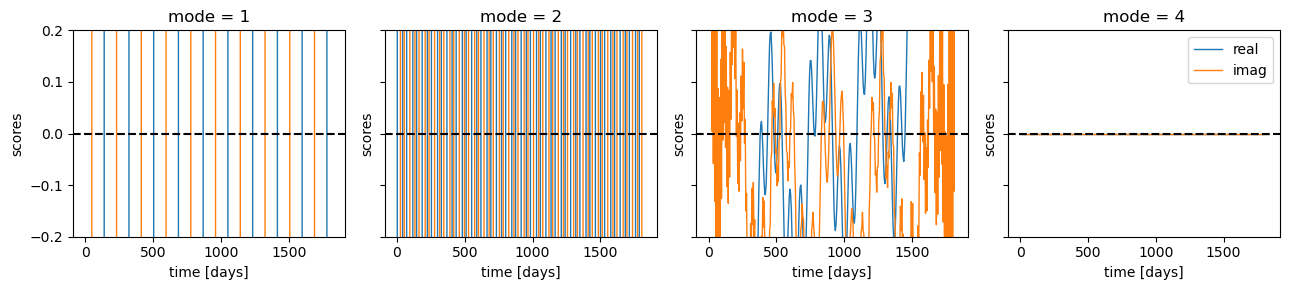

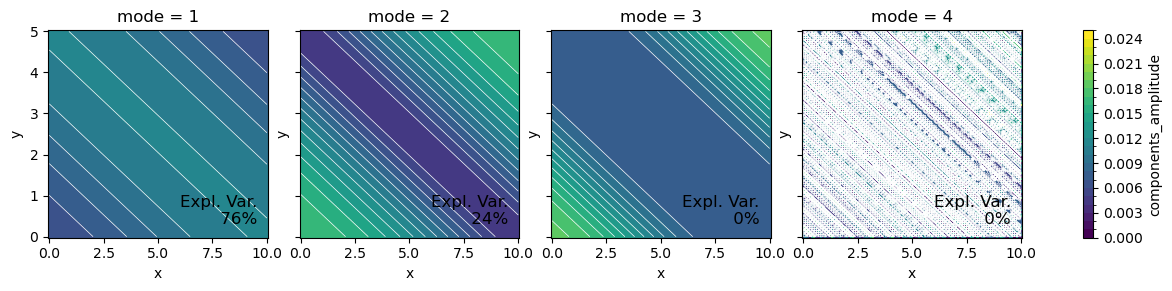

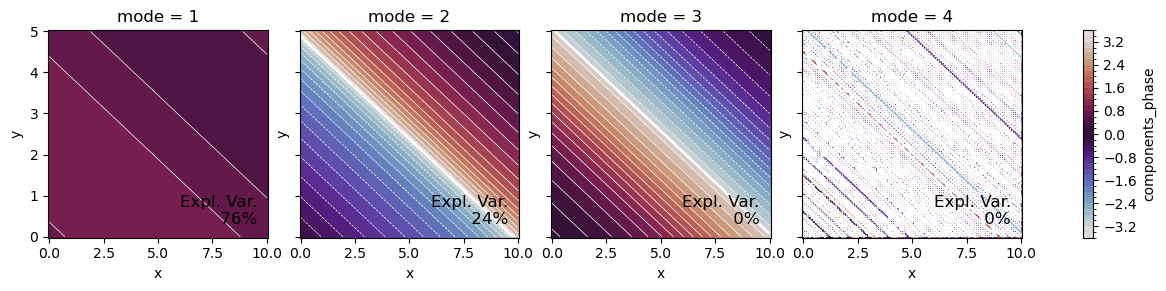

In [12]:
model = rt_eof.HEOF_func(v)

This is a demonstration how to interprete the figures below. The HEOF scores show the temporal evolution of the pattern (components_amplitude and components_phase). A homogenous phase indicates that the signal does not travel spatially. In this case mode 1 shows a the spatially homogenous anual strengthening and weakening, while mode 2 show the semi-annual signal wich is propageting through the domain (as presented by the phase). Mode 3 and 4 are noise and irrelavant (explained variance is closed to zero).

In the following I applied the same method to the glider and ET EW velocity sections

### Glider data
Resampled to 15 days and mean removed

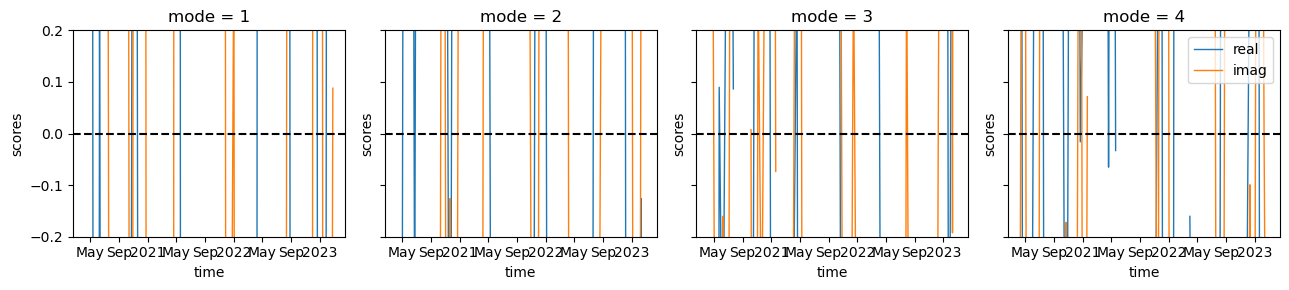

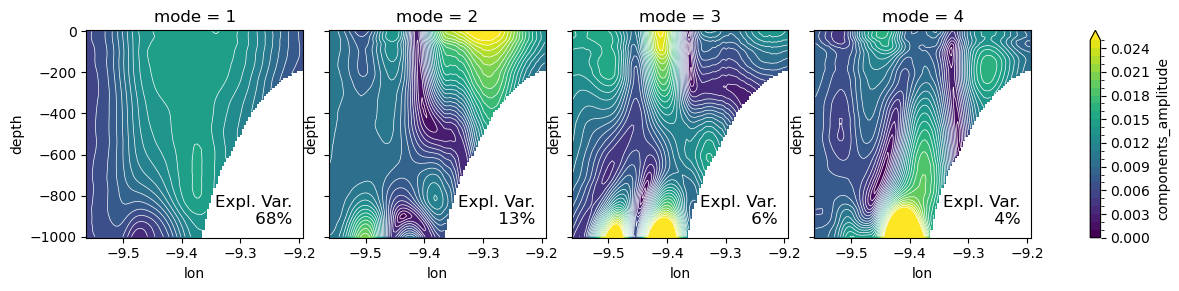

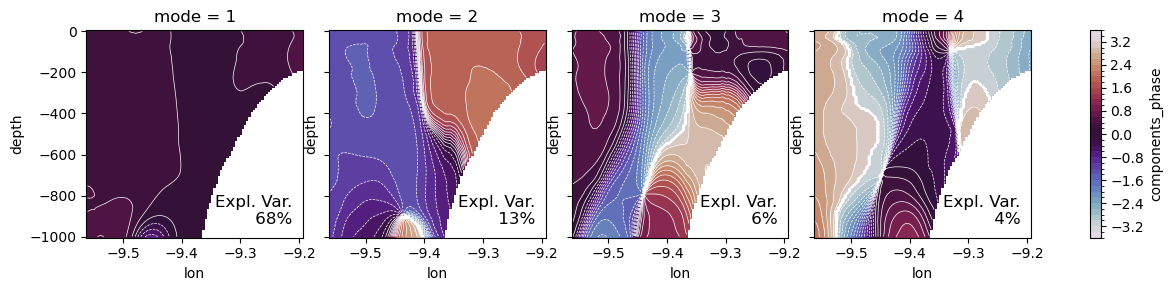

In [13]:
# remove mean
v_anomaly = ds_glider.vcur.resample(time="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('time',keep_attrs=True)

glider_HEOF = rt_eof.HEOF_func(v_anomaly,dim='lon')

The first HEOF seems to display a strengthing/weakening of the velocity field in time (homogenous phase) in the entire domain explaining 68% of the variance in the glider section. This agrees well with the phase and explained variance of HEOF 1 of the reconstructed velocity section using EB1 and GLORYS12v2 output at the ADCP position following Fraser et al. (2022). Here the temporal strengthening/weakening explains up to 83% (see figures below for different time periods). However, comparing the amplitudes between glider and reconstructed velocities the later are dominated by velocities at EB1 while the glider section show highest amplitudes between EB1 and the ADCP.

Undercurrent in glider HEOF 1 is visible with low amplitudes and a up to ~90 degree phase shift (dark red to dark blue ~90)

The second HEOF I would interprete a zonal shift of the slope current with negative velocity to the west of the slope current when the slope current sits shallow in the east onto the shelf and vice versa. Again, HEOF2 from the reconstructed veloctiy field (Fraser et al., 2022) agrees well with the glider results. The zero crossing in the reconstructed velocity fields seems to be too far west compared to glider sections.

Again, undercurrent in glider HEOF 2 visible with low amplitudes/high east/west of its core in HEOF1. Phase shift of ~180 degree between the high/low amplitudes --> zonally migration? --> see if present in ship ladcp?

HEOF 3&4 from the glider sections are quite similar and more difficult to interprete. Together they explain up to 9%. I am wondering whether this depicts the vertical migration of the under current or some kind of recirculation between EB1 and the ADCP position? This feature is not visible in the velocity reconstruction from the moored observation (Fraser et al., 2022) which make sense as we do not have any information what happens between EB1 and the ADCP.

### Rockall EW reconstruction
#### Full timeseries (2014-2022) 
original resolution, mean removed


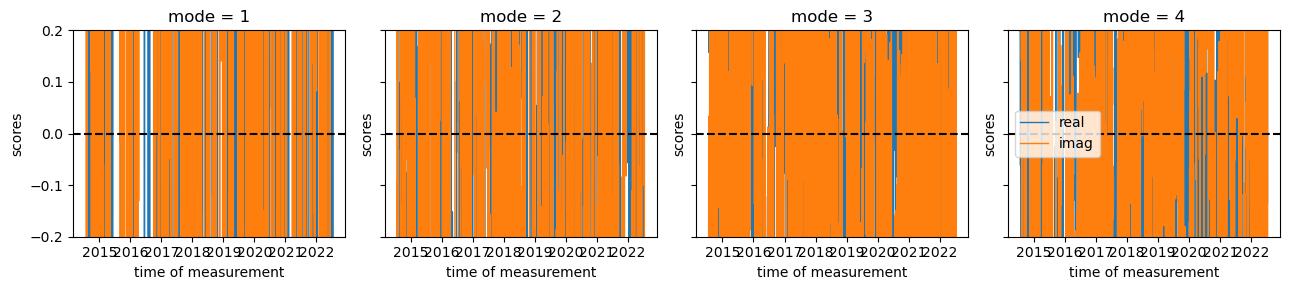

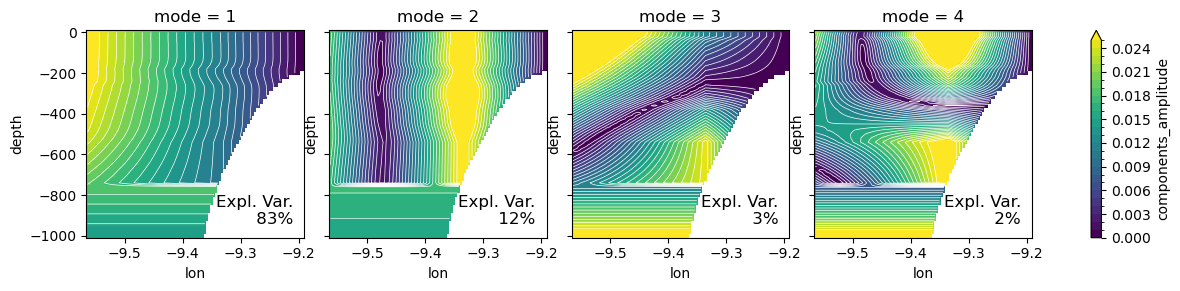

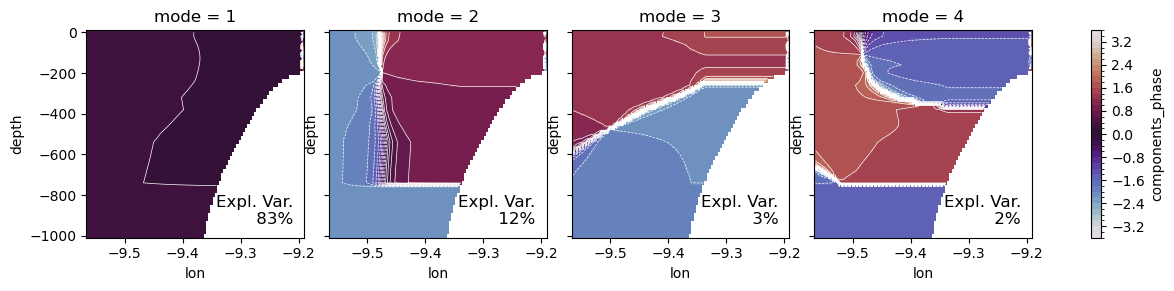

In [14]:
v_anomaly = ds_q_RT.v.rename({'TIME':'time'})

# remove mean
# v_anomaly = v_anomaly.resample(time="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('time',keep_attrs=True)

model = rt_eof.HEOF_func(v_anomaly,dim='lon')

#### 2020-2022 
original resolution - mean removed

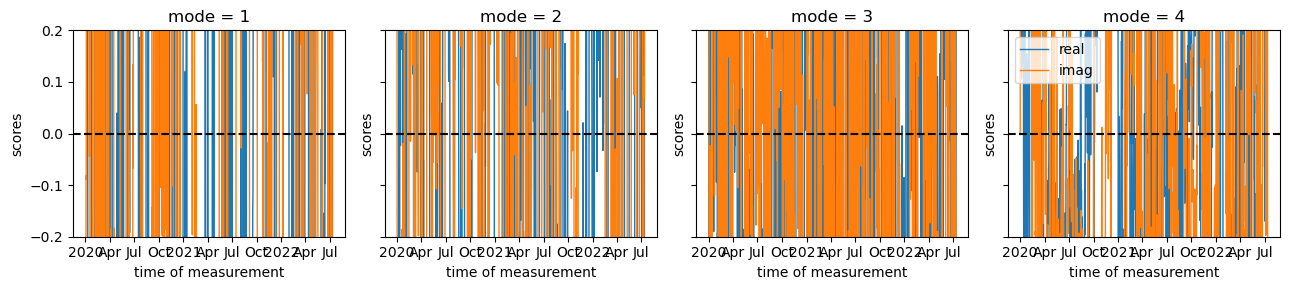

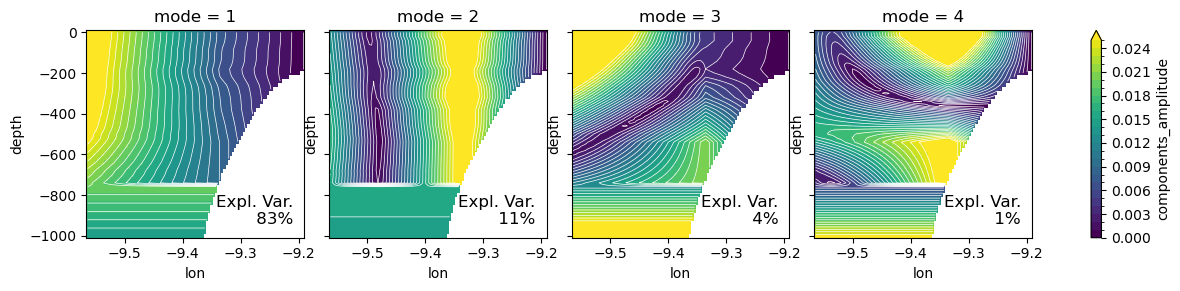

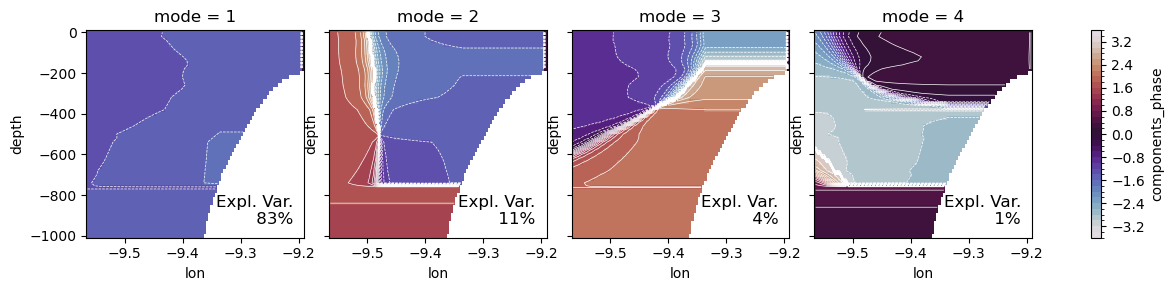

In [15]:
v_anomaly = ds_q_RT.v.sel(TIME=slice('2020','2022')).rename({'TIME':'time'})

# remove mean
# v_anomaly = v_anomaly.resample(time="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('time',keep_attrs=True)

model = rt_eof.HEOF_func(v_anomaly,dim='lon')

#### Interp on glider time stamps
15D averaged and mean removed

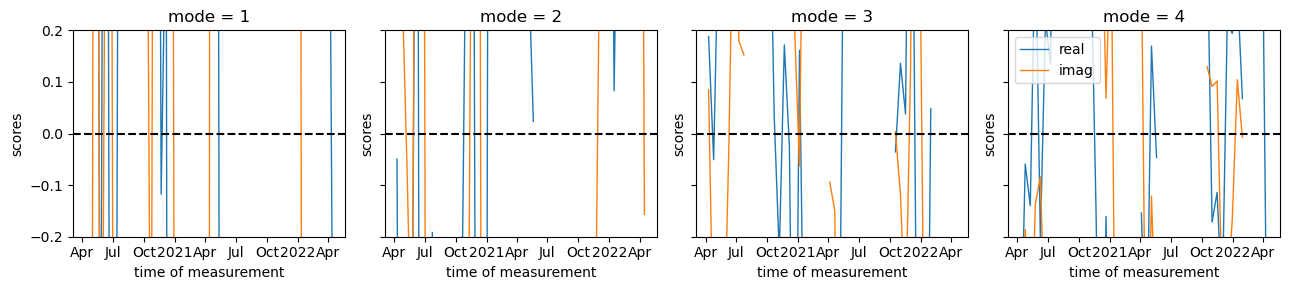

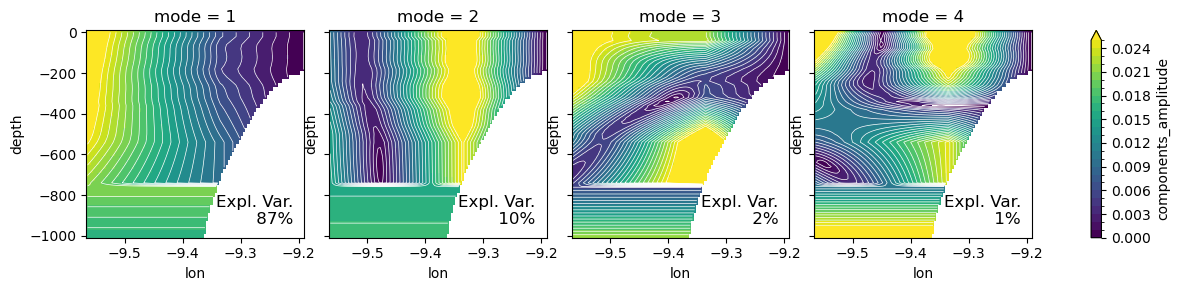

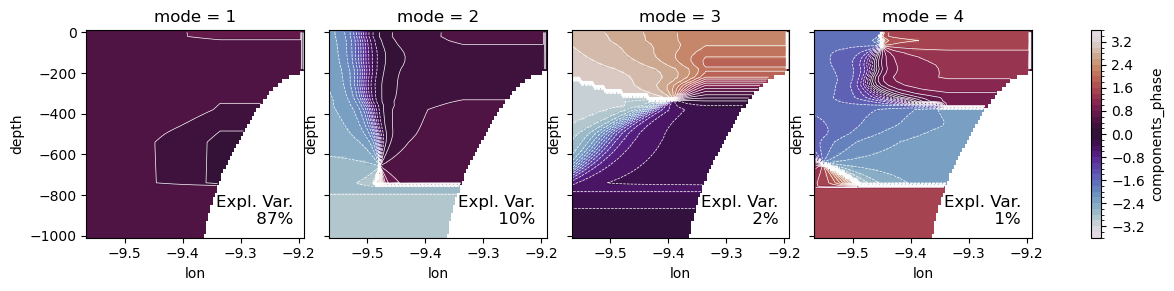

In [16]:
v_anomaly = ds_q_RT.v.interp(TIME=ds_glider.time.values).rename({'TIME':'time'})
# remove mean
v_anomaly = v_anomaly.resample(time="15D").mean()
v_anomaly = v_anomaly - v_anomaly.mean('time',keep_attrs=True)

model = rt_eof.HEOF_func(v_anomaly,dim='lon')

# Reconstruction
Idea: Use the spatial pattern from the HEOF ($X$) reproduce velocity section ($y$) for the eastern wedge:
$$
X \alpha = y
$$

Therefore we first need to find alpha. We know y at certain locations: the meridional velocities from RTEB1 and GLORYS2v12-ADCP. We can stack them together to get $y_{loc}$, use the HEOF at the mooring positions ($X_{loc}$) and find alpha by solving:

$$
X_{loc}^{T}X_{loc} \alpha = X_{loc}^{T}y_{loc}
$$
$$
\alpha = (X_{loc}^{T}X_{loc})^{-1} X_{loc}^{T}y_{loc}
$$



## Recreate glider section using glider obs at point of ERTEB1 and RTADCP for some stats

In [17]:
# Create y from glider data for linear regression (X'X*alpha=X'y)
#get mean glider section at mooring positions
glider_locs = ds_glider.vcur.sel(lon=[ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTADCP],method='nearest')
glider_locs['depth']=np.abs(glider_locs.depth)

# Remove glider sections temporal mean from X
ds_y= (glider_locs - glider_locs.mean('time')).compute()

# get HEOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_HEOF.components().sel(lon=[ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTADCP],method='nearest').compute()

# get alpha & reconstruct velocity fields
v_rec_glider_moor = rt_eof.rec_v_sec(ds_X,ds_y,glider_HEOF,ds_glider.vcur,HEOF=True)

In [18]:
# Create y from glider data for linear regression (X'X*alpha=X'y)
#Use entire glider section for recreation
glider_locs = ds_glider.vcur
glider_locs['depth']=np.abs(glider_locs.depth)

# Remove glider sections temporal mean from X
ds_y= (glider_locs - glider_locs.mean('time')).compute()

# get HEOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_HEOF.components().compute()

# get alpha & reconstruct velocity fields
v_rec_glider_full = rt_eof.rec_v_sec(ds_X,ds_y,glider_HEOF,ds_glider.vcur,HEOF=True)

In [19]:
# rt_eof.plot_mean_section(ds_glider,ds_q_RT,v_rec_glider_moor)
# rt_eof.plot_mean_section(ds_glider,ds_q_RT,v_rec_glider_moor,mode_no=[1,2],mean=True)
# rt_eof.plot_mean_section(ds_glider,ds_q_RT,v_rec_glider_full,mode_no=[1,2],mean=True)

## Recreate sections from moorings

In [20]:
# Create y from moored velocity data for linear regression (X'X*alpha=X'y)
#get mean glider section at mooring positions
glider_locs = ds_glider.vcur.sel(lon=[ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTADCP],method='nearest').mean('time').compute()
glider_locs['depth']=np.abs(glider_locs.depth)

# Get RTEB1 meridional velocity
v_RTEB1=(ds_RT.V_EAST/1e2).interp(depth=('depth',glider_locs.depth.data)).rename({'TIME':'time'}).drop('PRES')

# Get Glorys data at ADCP station and apply corretions
v_GLO_RTADCP = ds_GLORYS.vo.interp(longitude=glider_locs.lon.sel(lon=[ds_RT_loc.lon_RTADCP],method='nearest').data,
                    latitude=ds_RT_loc.lat_RTADCP,
                    time=('time',v_RTEB1.time.data),
                    depth=('depth',glider_locs.depth.data)) + rtp.corr_model

# Duplicate top GLORYS-ADCP values
mask = v_GLO_RTADCP
mask = (mask.notnull()+mask.shift(depth=-1).notnull())
v_GLO_RTADCP = v_GLO_RTADCP.interpolate_na(dim="depth", method="nearest", fill_value="extrapolate")
v_GLO_RTADCP = v_GLO_RTADCP.where(mask).rename({'longitude':'lon'})


# combinde both to one matrix (time,depth,lon)
ds_y = xr.concat([v_RTEB1,v_GLO_RTADCP.drop_vars(['latitude','lon'])], dim="lon")
ds_y['lon']=glider_locs.lon.data

# Remove glider sections temporal mean from X
ds_y = (ds_y-glider_locs).compute()

# get HEOF components at mooring positions as X for linear regression (X'X*alpha=X'y)
# initial X matrix (mode,lon,depth)
ds_X = glider_HEOF.components().sel(lon=[ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTADCP],method='nearest').compute()

# get alpha & reconstruct velocity fields
v_rec = rt_eof.rec_v_sec(ds_X,ds_y,glider_HEOF,ds_glider.vcur,HEOF=True)

## Mean section of glider, RT EW full and HEOF-reconstructions
- Glider - velocity from glider sections May 2020- Feb 2023
- RT EW full - full data set (Jul 2014- Jul 2022) - velocity section from eastern wedge transport reconstruction (Fraser et al., 2022)  
- HEOF [X] full - HEOF reconstruction averaging over [X] modes for the full mooring time period (Jul 2014- Jul 2022)
- HEOF [X] resampled - data interpolated on Glider time stamp (May 20-Jul 23) using HEOF reconstruction averaged over [X] modes 
    !NOTE: mooring time series ends in July 2022 and does not cover full glider timeseries!

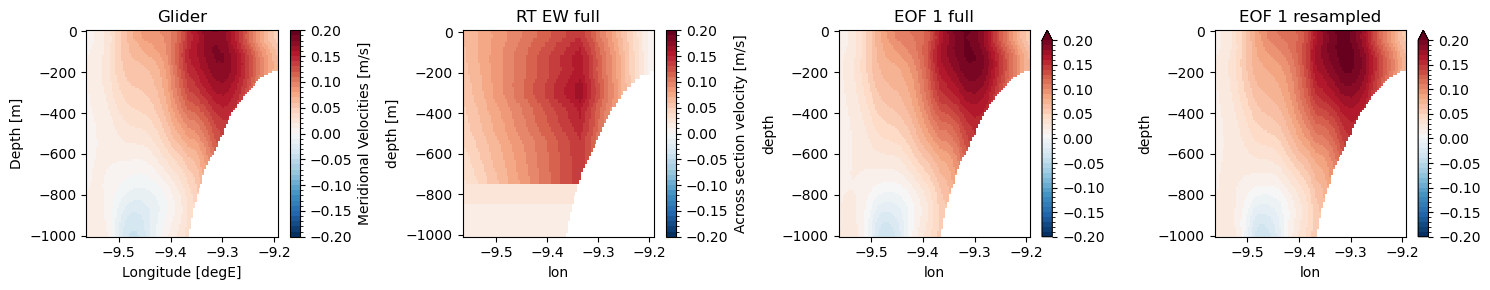

In [21]:
rt_eof.plot_mean_section(ds_glider,ds_q_RT,v_rec)

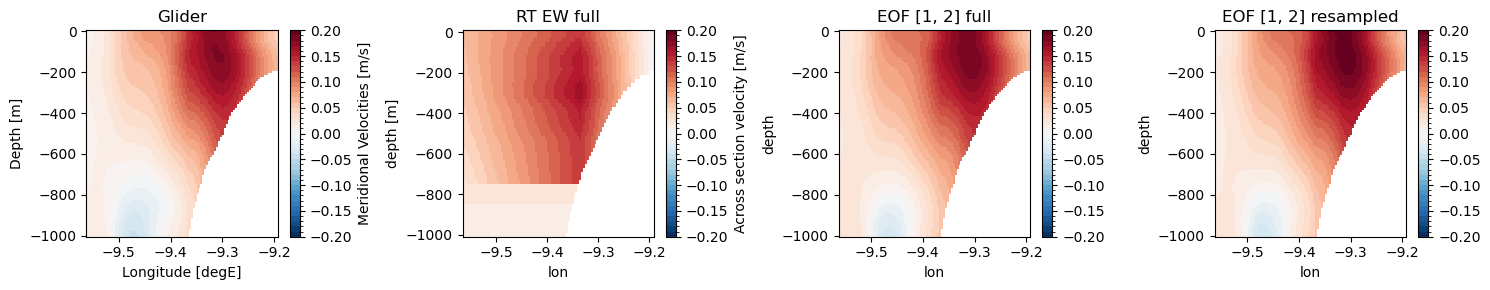

In [22]:
rt_eof.plot_mean_section(ds_glider,ds_q_RT,v_rec,mode_no=[1,2],mean=True)

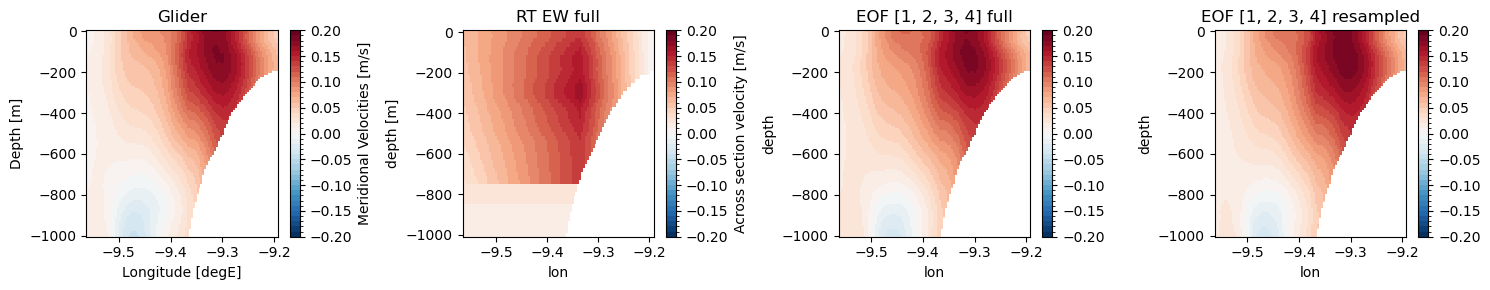

In [23]:
rt_eof.plot_mean_section(ds_glider,ds_q_RT,v_rec,mode_no=[1,2,3,4],mean=True)

## Seasonal Cycle

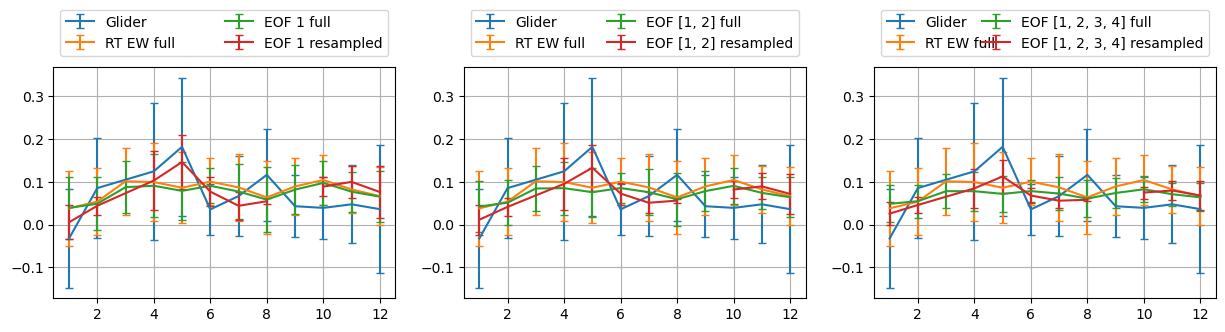

In [24]:
fig,axs = plt.subplots(1,3,figsize=[15,3])
ax=axs[0]
rt_eof.plot_seasonal_cycle(ds_glider,ds_q_RT,v_rec,ax=ax,mode_no=1,mean=False)
ax=axs[1]
rt_eof.plot_seasonal_cycle(ds_glider,ds_q_RT,v_rec,ax=ax,mode_no=[1,2],mean=True)
ax=axs[2]
rt_eof.plot_seasonal_cycle(ds_glider,ds_q_RT,v_rec,ax=ax,mode_no=[1,2,3,4],mean=True)

## Time series in original resolution 2020-2022 - spatially averaged velocity

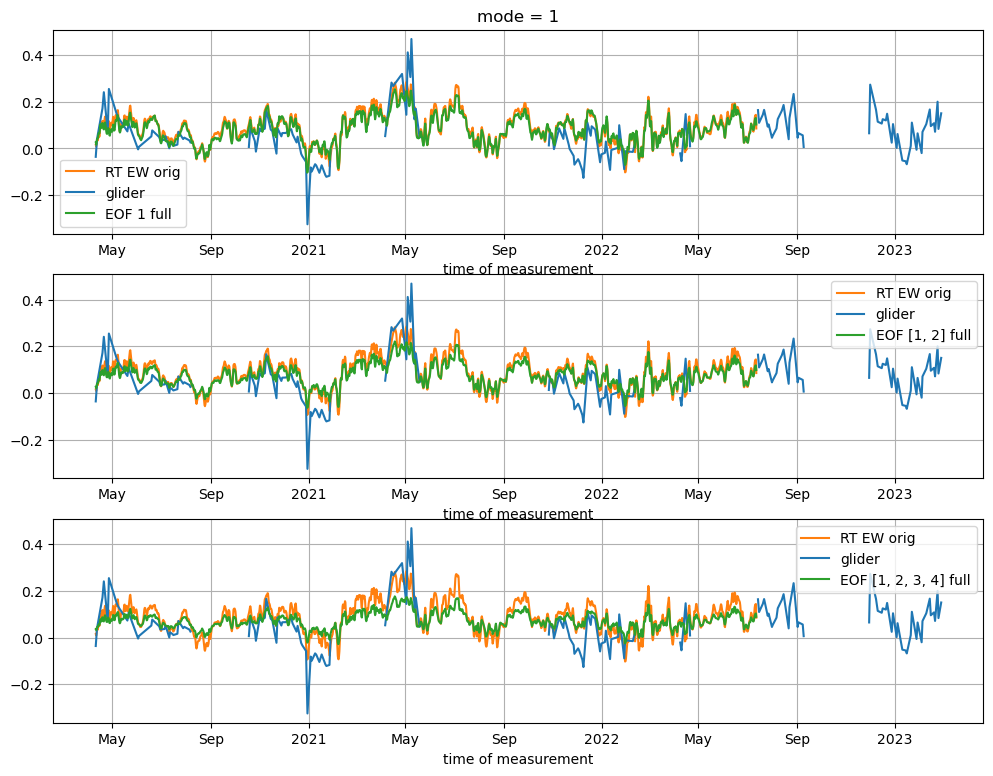

In [25]:
fig,axs = plt.subplots(3,1,figsize=[12,9])
ax=axs[0]
rt_eof.plot_longterm(ds_glider_nan.interpolate_na(dim="time", method="linear",max_gap='5D'),ds_q_RT,v_rec,ax=ax,mode_no=1,mean=False)
ax=axs[1]
rt_eof.plot_longterm(ds_glider_nan.interpolate_na(dim="time", method="linear",max_gap='5D'),ds_q_RT,v_rec,ax=ax,mode_no=[1,2],mean=True)
ax=axs[2]
rt_eof.plot_longterm(ds_glider_nan.interpolate_na(dim="time", method="linear",max_gap='5D'),ds_q_RT,v_rec,ax=ax,mode_no=[1,2,3,4],mean=True)

HEOF mode 1 seems to best to recontruct velocity fields. No additional values gained for variability. Only better representation of slope current structure.